## Face Recognition (from Python Data Science Handbook by Jake VanderPlas)

As an example of support vector machines in action, let's take a look at the facial recognition problem.
We will use the Labeled Faces in the Wild dataset, which consists of several thousand collated photos of various public figures.
A fetcher for the dataset is built into Scikit-Learn:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
import ssl

In [3]:
ssl._create_default_https_context = ssl._create_unverified_context
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's plot a few of these faces to see what we're working with:

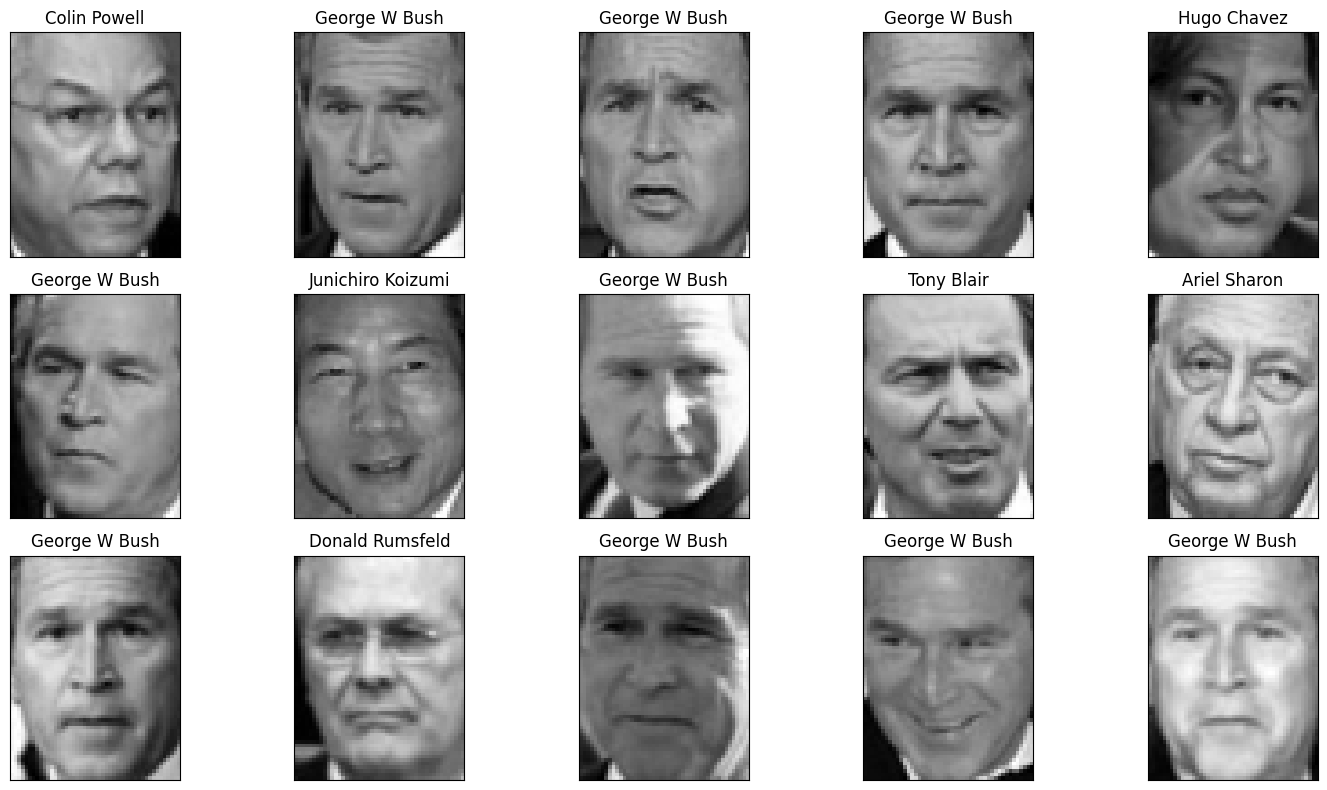

In [4]:
fig, ax = plt.subplots(3, 5, figsize=(15, 8))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
    axi.set_title(faces.target_names[faces.target[i]])
plt.tight_layout()

Each image contains [62×47] or nearly 3,000 pixels.
We could proceed by simply using each pixel value as a feature, but often it is more effective to use some sort of preprocessor to extract more meaningful features; here we will use a principal component analysis (we will learn about PCA later) to extract 150 fundamental components to feed into our support vector machine classifier.
We can do this most straightforwardly by packaging the preprocessor and the classifier into a single pipeline:

In [5]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [6]:
pca = PCA(n_components=150, whiten=True, random_state=42)

For the sake of testing our classifier output, we will split the data into a training and testing set:

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    faces.images.reshape(len(faces.images), -1),
    faces.target, test_size=0.2, random_state=0
)

Finally, we can use a grid search cross-validation to explore combinations of parameters.
Here we will adjust ``C`` (which controls the margin hardness) and ``gamma`` (which controls the size of the radial basis function kernel), and determine the best model:

In [ ]:
from sklearn.model_selection import GridSearchCV

In [10]:
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

param_grid = {'svc__C': [1, 5, 10, 50], 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}

grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'svc__C': 50, 'svc__gamma': 0.005}
0.8423169681309217


The optimal values fall toward the middle of our grid; if they fell at the edges, we would want to expand the grid to make sure we have found the true optimum.

Now with this cross-validated model, we can predict the labels for the test data, which the model has not yet seen:

In [14]:
grid.predict(X_test)

array([3, 7, 2, 4, 3, 7, 4, 7, 2, 3, 2, 2, 3, 4, 3, 1, 6, 7, 4, 3, 4, 1,
       3, 6, 3, 1, 3, 1, 3, 1, 3, 1, 3, 7, 7, 3, 7, 2, 4, 3, 4, 3, 3, 3,
       1, 0, 3, 3, 7, 2, 7, 3, 1, 3, 3, 3, 3, 3, 3, 1, 7, 6, 1, 1, 0, 3,
       1, 4, 5, 3, 3, 1, 6, 5, 1, 2, 4, 2, 2, 2, 1, 7, 3, 2, 2, 3, 1, 3,
       0, 3, 5, 2, 6, 3, 3, 1, 1, 3, 3, 7, 1, 3, 3, 1, 3, 7, 7, 3, 7, 6,
       4, 1, 3, 3, 3, 1, 3, 3, 2, 3, 7, 3, 3, 4, 1, 3, 2, 4, 1, 3, 3, 3,
       1, 3, 4, 3, 3, 3, 3, 3, 3, 7, 4, 3, 3, 1, 3, 5, 6, 1, 2, 1, 1, 3,
       3, 7, 3, 3, 1, 7, 1, 3, 3, 3, 3, 1, 4, 3, 3, 1, 3, 7, 1, 0, 3, 3,
       3, 1, 2, 3, 6, 1, 2, 3, 3, 0, 3, 1, 3, 3, 1, 3, 0, 3, 3, 1, 3, 3,
       1, 1, 3, 5, 3, 2, 0, 3, 1, 3, 1, 7, 3, 3, 3, 3, 7, 2, 2, 3, 4, 1,
       2, 5, 4, 3, 3, 1, 6, 2, 3, 3, 7, 3, 3, 7, 7, 1, 1, 2, 2, 3, 2, 3,
       0, 1, 5, 4, 3, 3, 3, 3, 3, 3, 1, 5, 1, 0, 3, 1, 1, 3, 5, 3, 4, 3,
       2, 6, 6, 7, 3, 7])

Let's take a look at a few of the test images along with their predicted values:

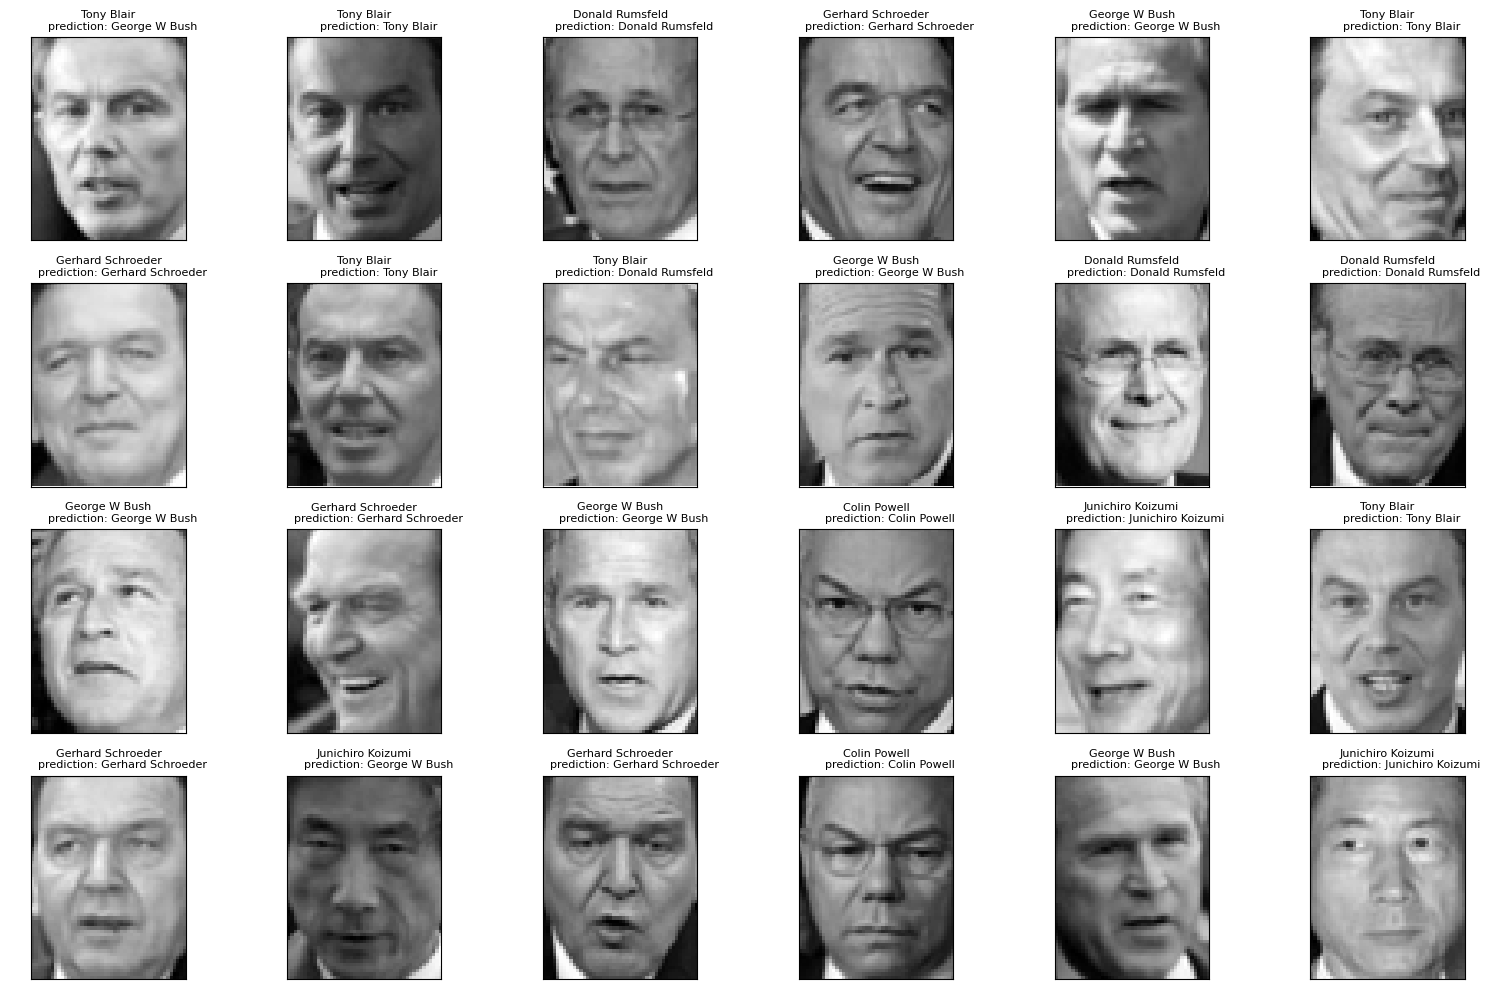

In [34]:
fig, ax = plt.subplots(4, 6, figsize=(16, 10))
y_pred = grid.predict(X_test)
missed_names = [] # for more info
for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i].reshape(62, 47), cmap="gray")
    axi.set(xticks=[], yticks=[])
    title = f"{faces.target_names[y_test[i]]}\n\
        prediction: {faces.target_names[y_pred[i]]}"
    axi.set_title(title, size=8)
    
    # just to check misses
    if faces.target_names[y_test[i]] != faces.target_names[y_pred[i]]:
        missed_names.append(faces.target_names[y_test[i]])
        
plt.tight_layout()

Out of this small sample, our optimal estimator mislabeled only a single face (Bush’s
face in the bottom row was mislabeled as Blair).
We can get a better sense of our estimator's performance using the classification report, which lists recovery statistics label by label:

In [35]:
# My model had a couple of misses
# quick way to check missed predictions above
missed_names

['Tony Blair', 'Tony Blair', 'Junichiro Koizumi']

In [37]:
from sklearn.metrics import classification_report

In [38]:
print(classification_report(y_test, y_pred, target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.62      0.73        13
     Colin Powell       0.83      0.93      0.88        46
  Donald Rumsfeld       0.81      0.79      0.80        28
    George W Bush       0.80      0.94      0.87        99
Gerhard Schroeder       0.89      0.74      0.81        23
      Hugo Chavez       1.00      0.56      0.72        16
Junichiro Koizumi       1.00      0.79      0.88        14
       Tony Blair       0.85      0.74      0.79        31

         accuracy                           0.84       270
        macro avg       0.88      0.76      0.81       270
     weighted avg       0.85      0.84      0.83       270



We might also display the confusion matrix between these classes:

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

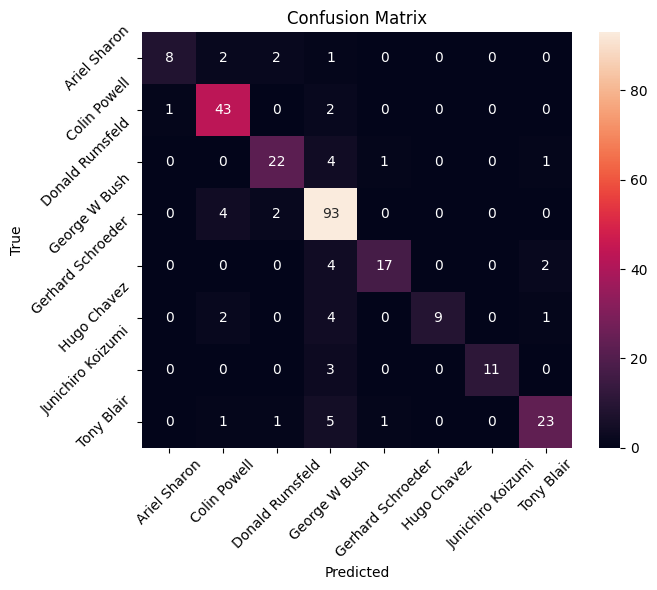

In [45]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()

This helps us get a sense of which labels are likely to be confused by the estimator.

For a real-world facial recognition task, in which the photos do not come pre-cropped into nice grids, the only difference in the facial classification scheme is the feature selection: you would need to use a more sophisticated algorithm to find the faces, and extract features that are independent of the pixellation.
For this kind of application, one good option is to make use of [OpenCV](http://opencv.org), which, among other things, includes pre-trained implementations of state-of-the-art feature extraction tools for images in general and faces in particular.

In [ ]:
"""reflection:"""
# if powell and rumsfeld cause highest confusion
# how come I missed Blair and Koizumi most often in my small test?